# Time Series Forecasting

From: https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651

Time Series is a collection of data points indexed based on the time they were collected. Most often, the data is recorded at regular time intervals. What makes Time Series data special?

Forecasting future Time Series values is a quite common problem in practice. Predicting the weather for the next week, the price of Bitcoins tomorrow, the number of your sales during Chrismas and future heart failure are common examples.

Time Series data introduces a “hard dependency” on previous time steps, so the assumption that independence of observations doesn’t hold. What are some of the properties that a Time Series can have?

**Stationarity**, **seasonality**, and **autocorrelation** are some of the properties of the Time Series you might be interested in.

A Times Series is said to be **stationary** when the mean and variance remain constant over time. A Time-Series has a trend if the mean is varying over time. Often you can eliminate it and make the series stationary by applying log transformation(s).

**Seasonality** refers to the phenomenon of variations at specific time-frames. eg people buying more Christmas trees during Christmas (who would’ve thought). A common approach to eliminating seasonality is to use differencing.

**Autocorrelation** refers to the correlation between the current value with a copy from a previous time (lag).
Why we would want to seasonality, trend and have a stationary Time Series? This is required data preprocessing step for Time Series forecasting with classical methods like ARIMA models. Luckily, we’ll do our modeling using Recurrent Neural Networks.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1)

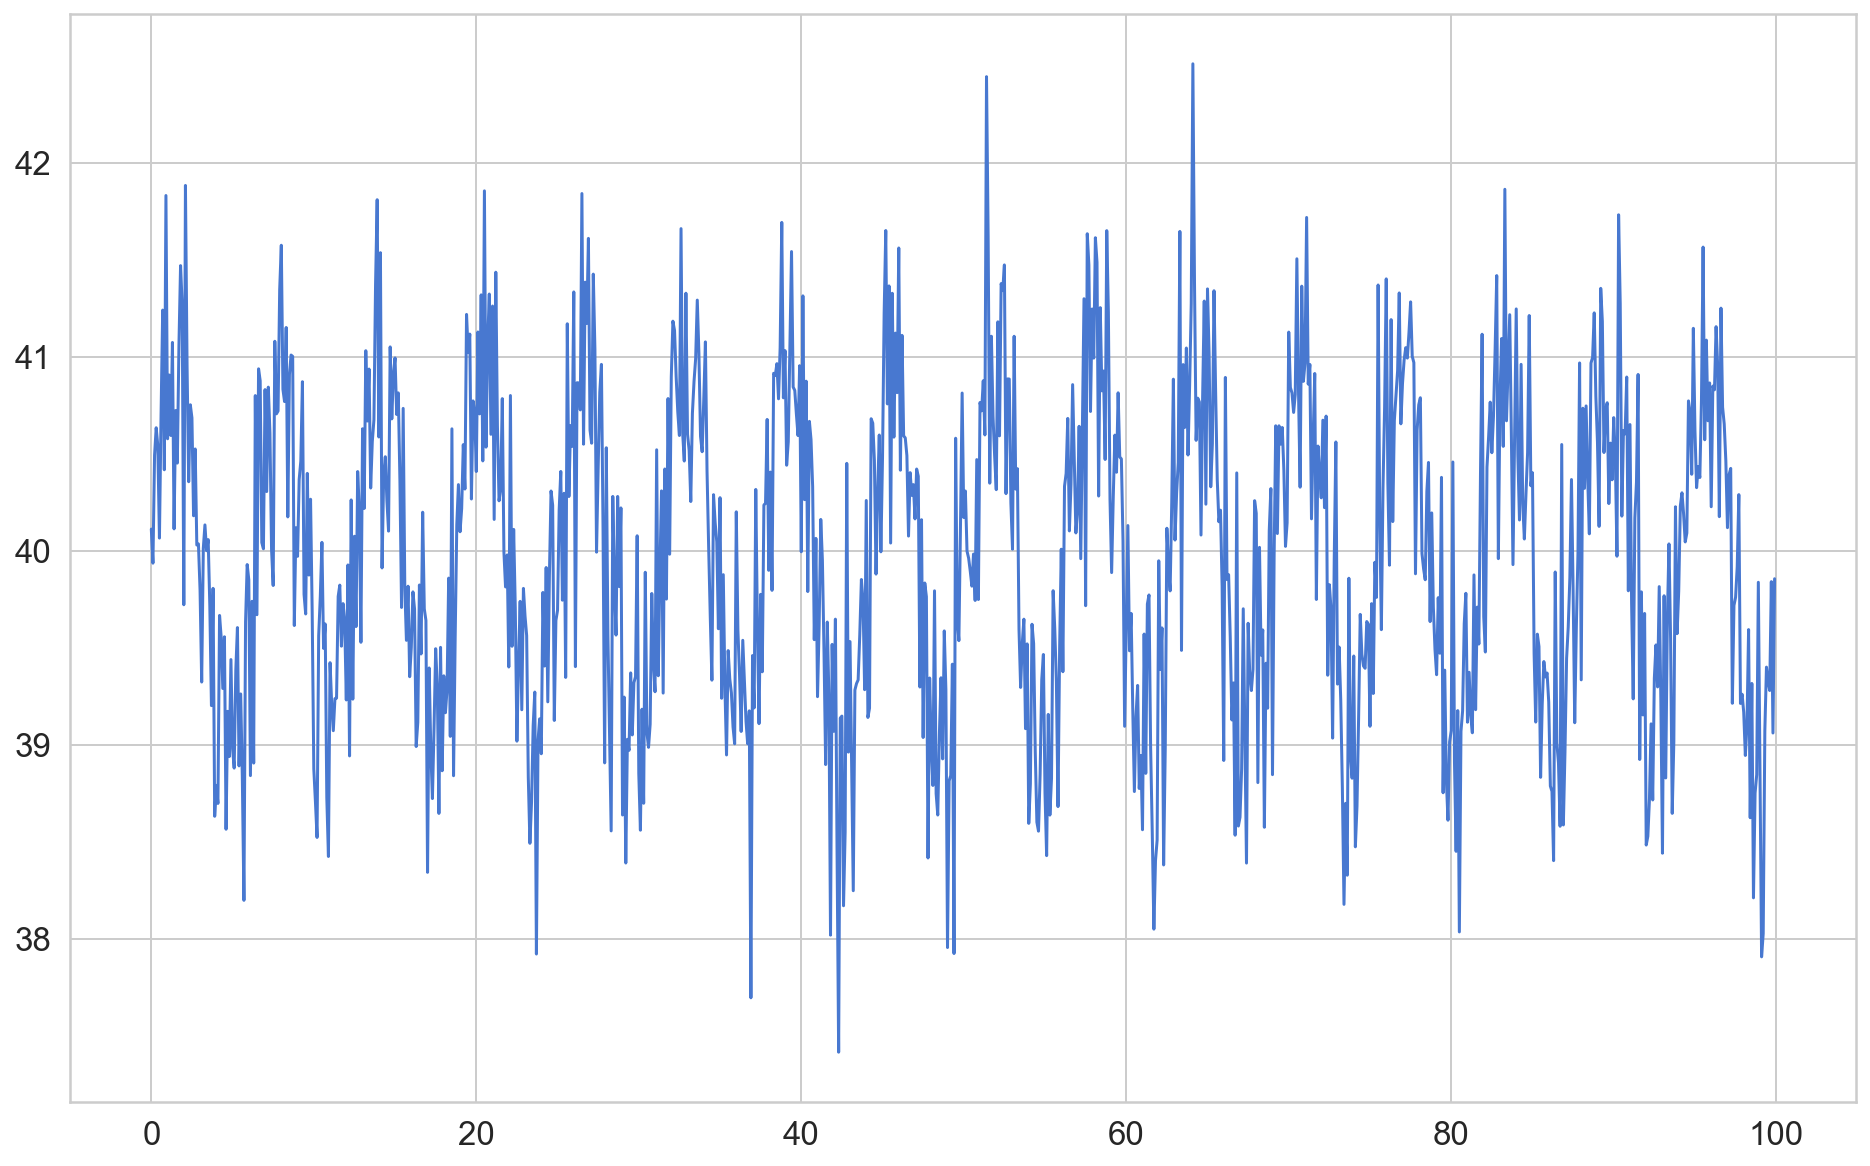

In [16]:
time = np.arange(0, 100, 0.1)
sin = np.sin(time ) + np.random.normal(scale=0.5, size=len(time)) + 40
plt.plot(time, sin)
plt.show()

## Data Preprocessing
We need to “chop the data” into smaller sequences for our model. But first, we’ll split it into training and test data:

In [4]:
df = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
train_size = int(len(df) * 0.6)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

600 400


Preparing the data for Time Series forecasting (LSTMs in particular) can be tricky. Intuitively, we need to predict the value at the current time step by using the history ( n time steps from it). Here’s a generic function that does the job:

The beauty of this function is that it works with univariate (single feature) and multivariate (multiple features) Time Series data. Let’s use a history of 10 time steps to make our sequences:

In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

The beauty of this function is that it works with univariate (single feature) and multivariate (multiple features) Time Series data. Let’s use a history of 10 time steps to make our sequences:

In [6]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)

(590, 10, 1) (590,)


We have our sequences in the shape (samples, time_steps, features). How can we use them to make predictions?

## Modeling

Training an LSTM model in Keras is easy. We’ll use the LSTM layer in a sequential model to make our predictions:

In [7]:
X_train

array([[[ 0.69967772],
        [ 0.56715026],
        [ 0.23848452],
        ...,
        [ 0.99680359],
        [ 1.28213245],
        [ 0.5607093 ]],

       [[ 0.56715026],
        [ 0.23848452],
        [-0.01294818],
        ...,
        [ 1.28213245],
        [ 0.5607093 ],
        [ 1.55016802]],

       [[ 0.23848452],
        [-0.01294818],
        [ 0.75853   ],
        ...,
        [ 0.5607093 ],
        [ 1.55016802],
        [ 1.04500716]],

       ...,

       [[ 3.58765492],
        [ 3.30344052],
        [ 3.69860848],
        ...,
        [ 2.07473554],
        [ 2.65924927],
        [ 3.37971504]],

       [[ 3.30344052],
        [ 3.69860848],
        [ 3.0506685 ],
        ...,
        [ 2.65924927],
        [ 3.37971504],
        [ 4.00400831]],

       [[ 3.69860848],
        [ 3.0506685 ],
        [ 2.05090215],
        ...,
        [ 3.37971504],
        [ 4.00400831],
        [ 2.8908774 ]]])

In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


The LSTM layer expects the number of time steps and the number of features to work properly. The rest of the model looks like a regular regression model. How do we train an LSTM model?

## Training

The most important thing to remember when training Time Series models is to not shuffle the data (the order of the data matters). The rest is pretty standard:

In [9]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Train on 531 samples, validate on 59 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
531/531 [==============================] - 1s 2ms/sample - loss: 0.5213 - val_loss: 0.3631
Epoch 2/30
531/531 [==============================] - 0s 642us/sample - loss: 0.4209 - val_loss: 0.3698
Epoch 3/30
531/531 [==============================] - 0s 602us/sample - loss: 0.4172 - val_loss: 0.3653
Epoch 4/30
531/531 [==============================] - 0s 587us/sample - loss: 0.4081 - val_loss: 0.3642
Epoch 5/30
531/531 [==============================] - 0s 627us/sample - loss: 0.3930 - val_loss: 0.3577
Epoch 6/30
531/531 [==============================] - 0s 622us/sample - loss: 0.3780 - val_loss: 0.3540
Epoch 7/30
531/531 [==============================] - 0s 666us/sample - loss: 0.3681 - val_loss: 0.3539
Epoch 8/30
531/531 [==============================] - 0s 678us/sample - loss: 0.3627 - val_loss: 0.3552
Epoch 9/30
531/531 [==============================] - 0s 655us/sample - loss:

Our dataset is pretty simple and contains the randomness from our sampling. After about 15 epochs, the model is pretty much-done learning.

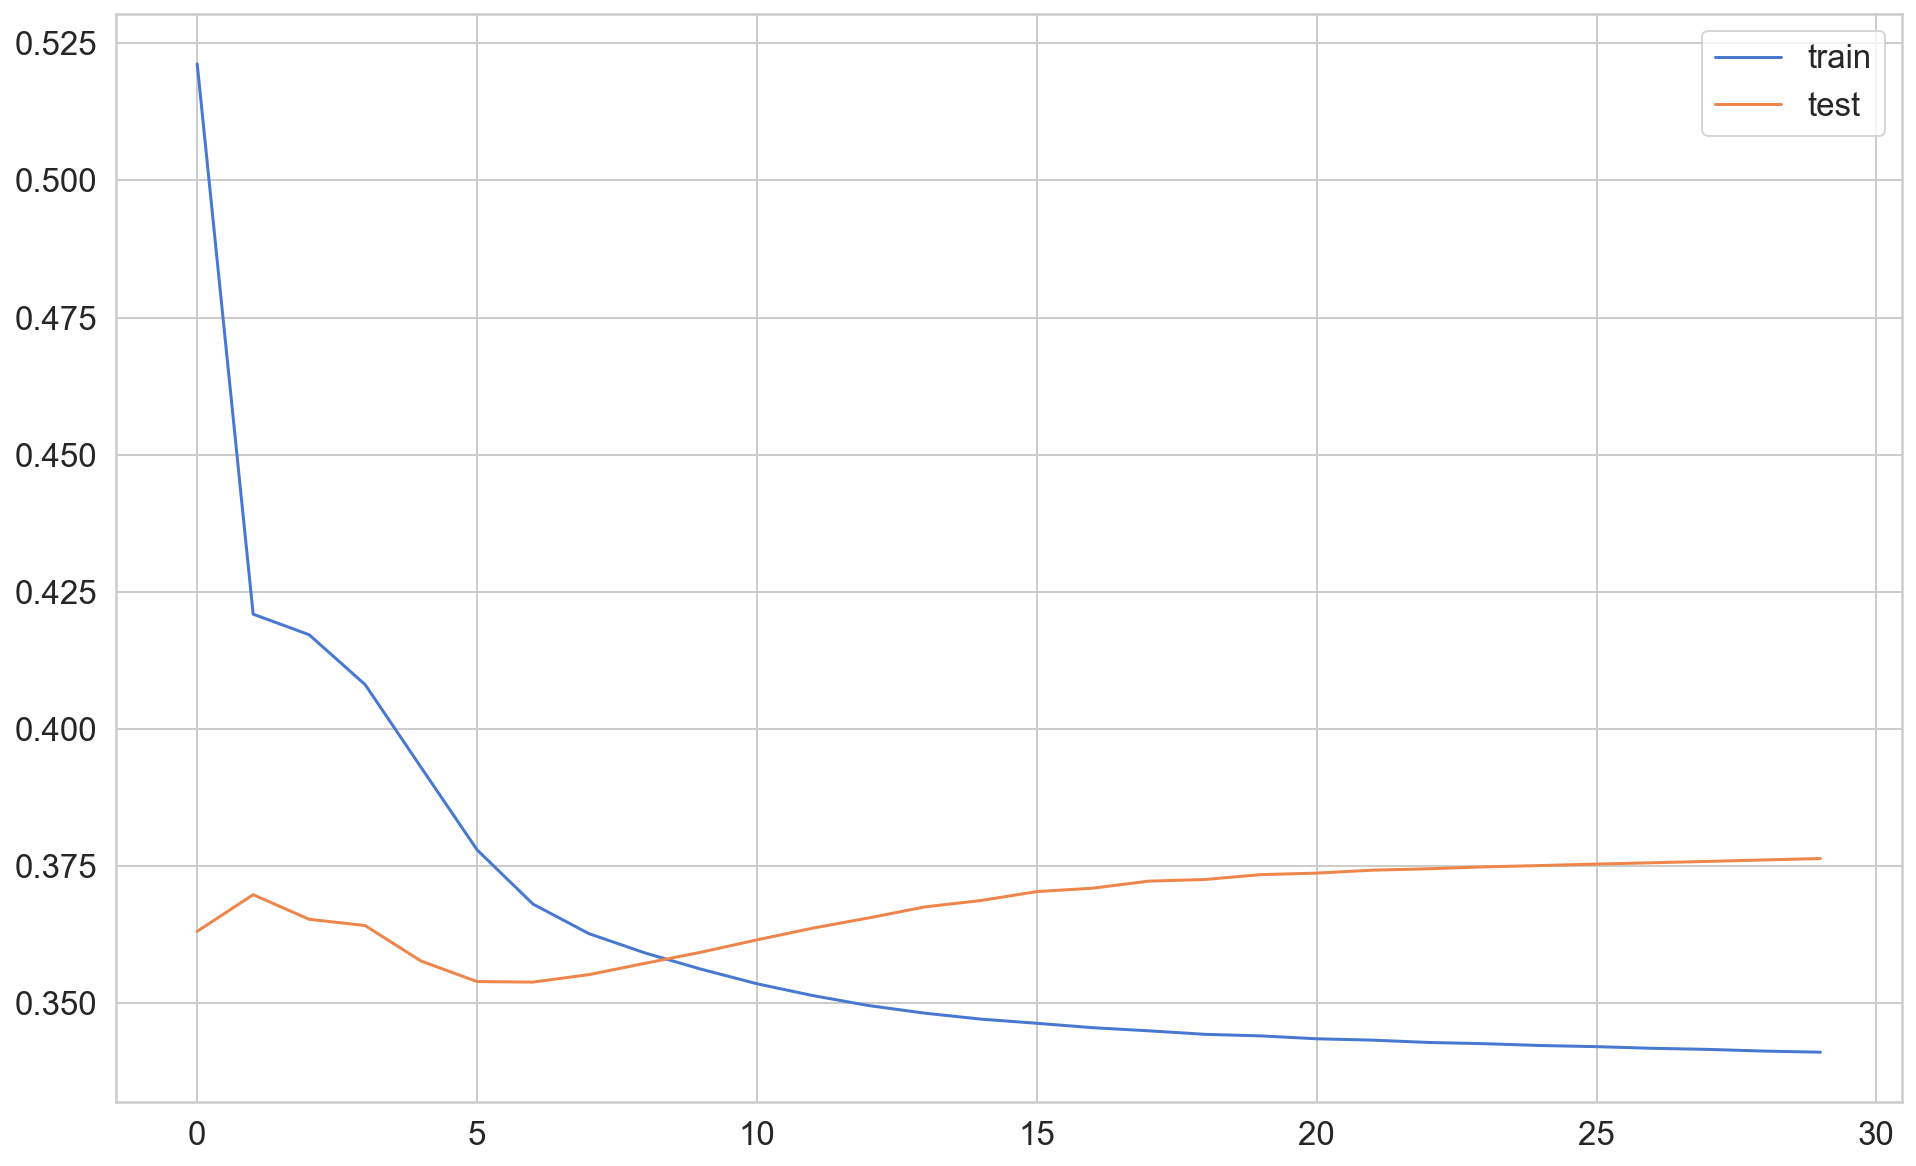

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Evaluation

We can plot the predictions over the true values from the Time Series. Let’s take some predictions from our model:

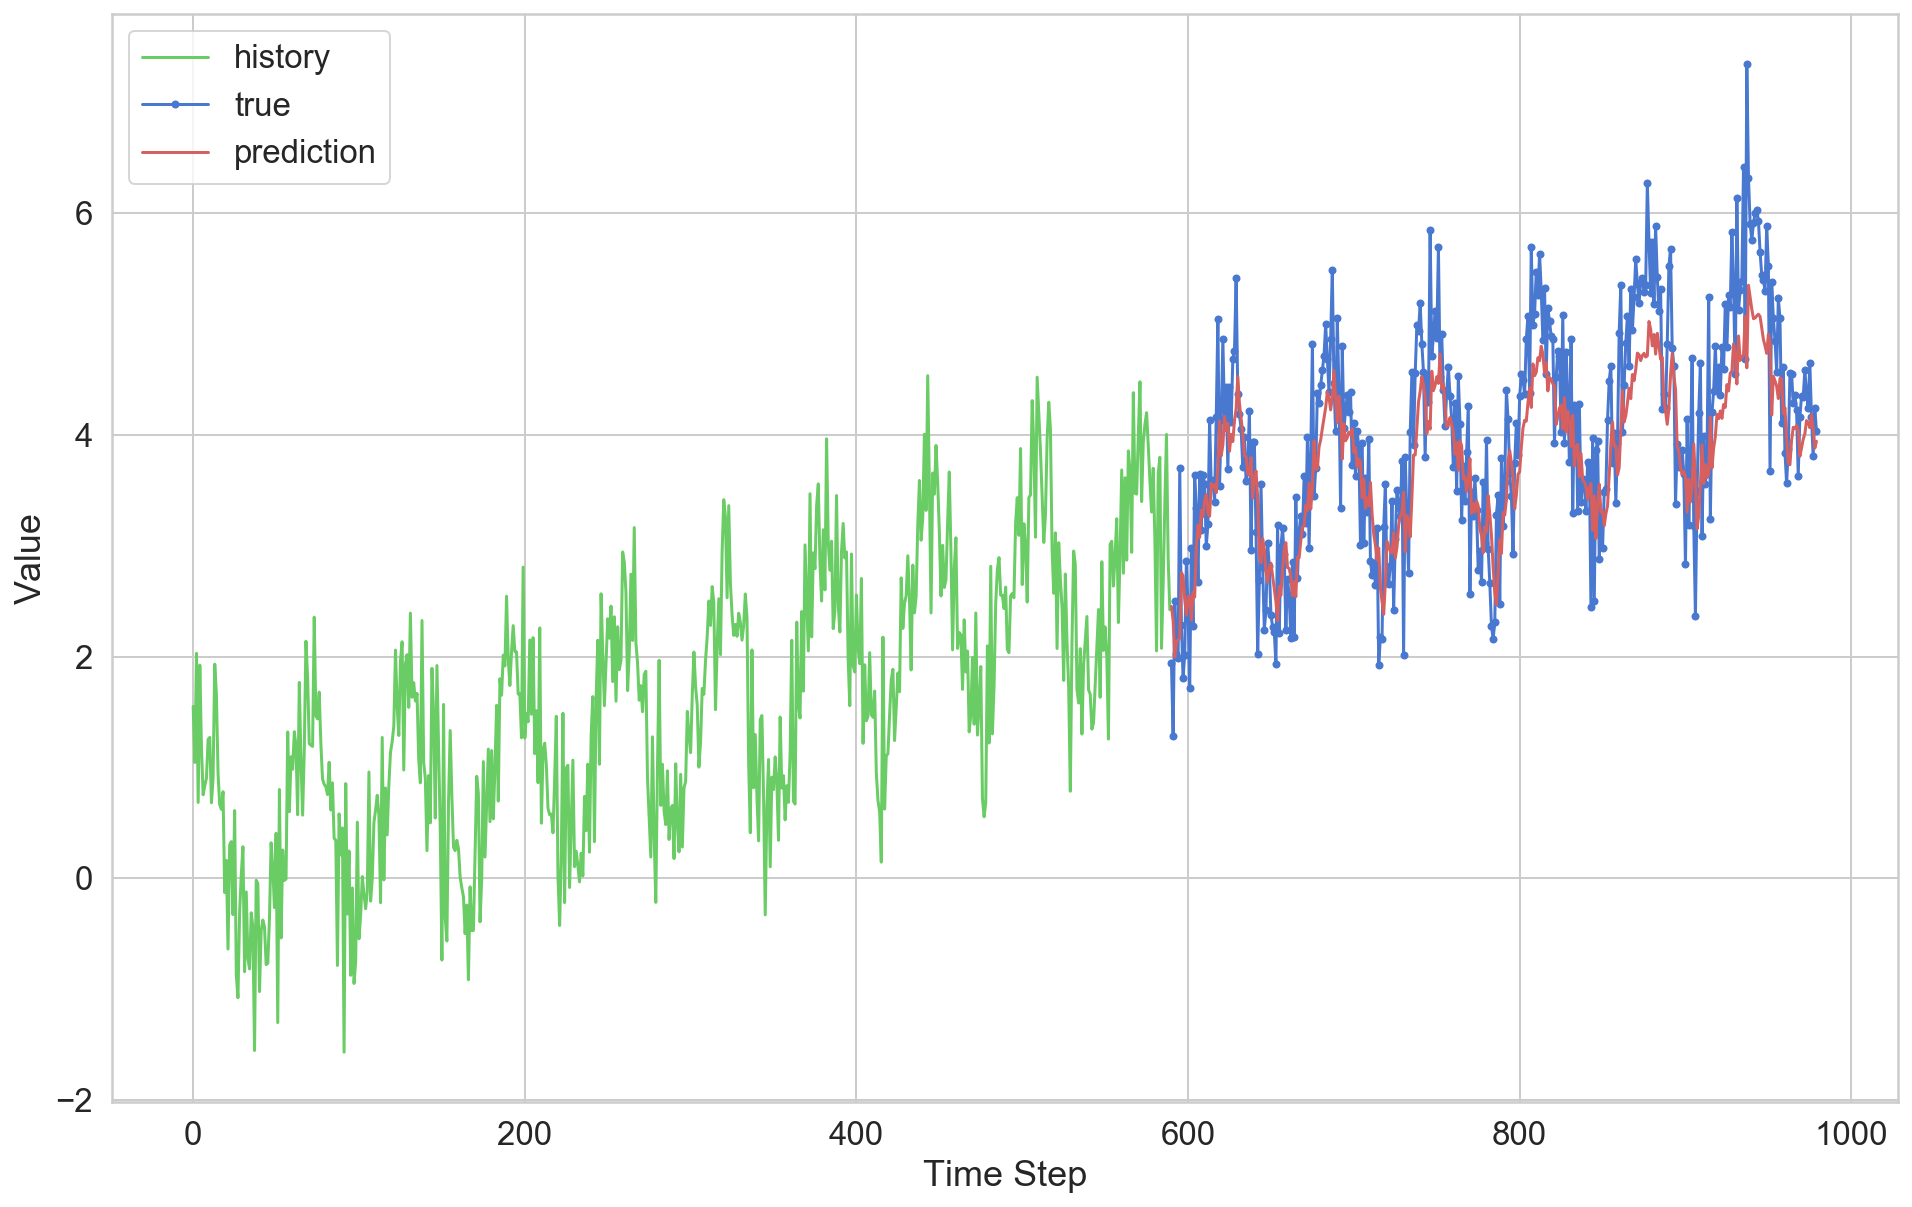

In [11]:
y_pred = model.predict(X_test)

plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Our predictions look really good on this scale. Let’s zoom in:

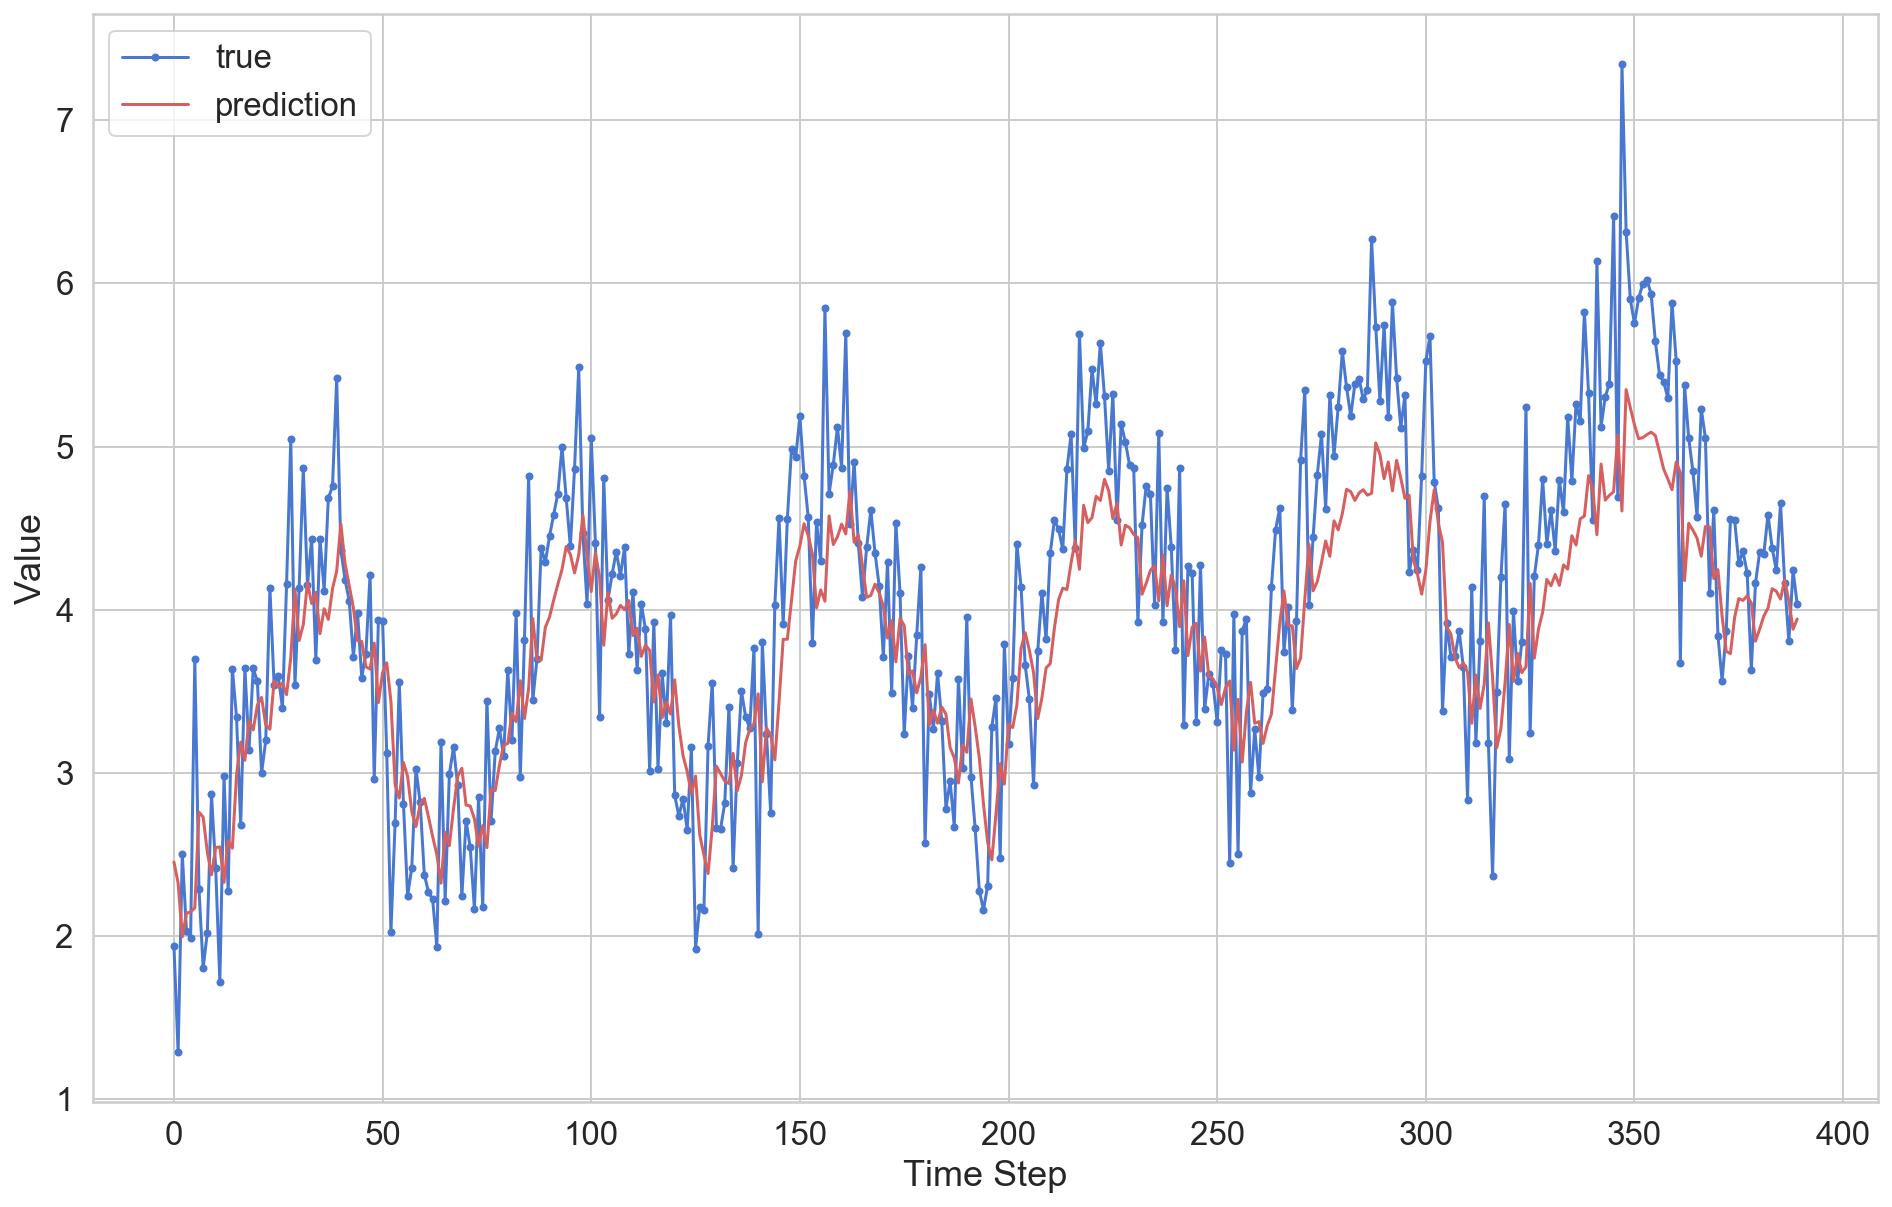

In [12]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Can we use this function to predict many steps in the future?

We will try to feed the previous predictions of the model to "generate" a new set of values in the future of the time serie. Do you think it will work?

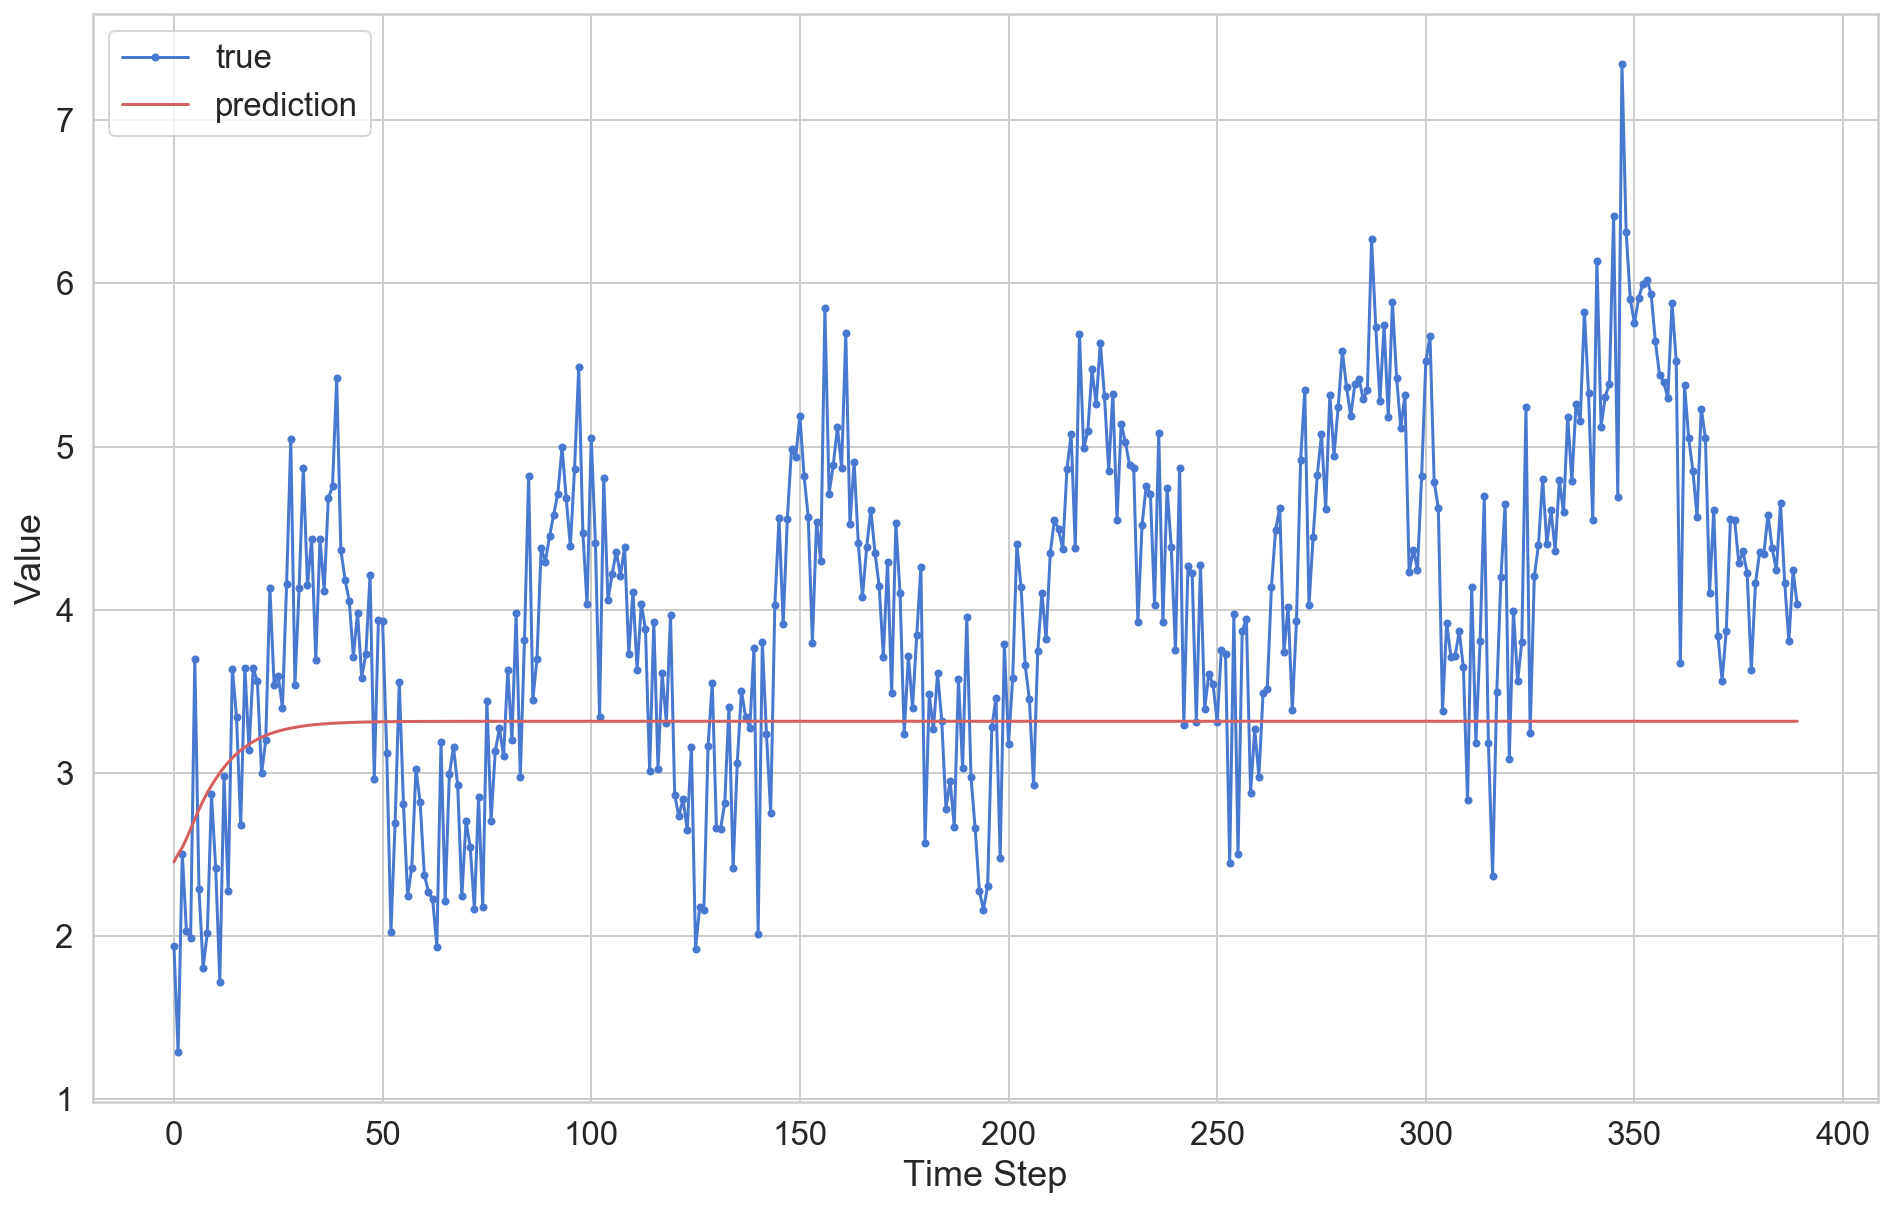

In [13]:
nSteps = X_test.shape[0]
xi = np.array([X_test[0]])
y_pred = []

for i in range(nSteps):
    yi = model.predict(xi)[0]
    y_pred.append(yi)
    #xi = np.reshape([np.insert(xi[0][1:], time_steps - 1, yi + np.random.normal(scale=0.2))], (1, time_steps, 1))
    xi = np.reshape([np.insert(xi[0][1:], time_steps - 1, yi)], (1, time_steps, 1))

plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

What about adding some noise?

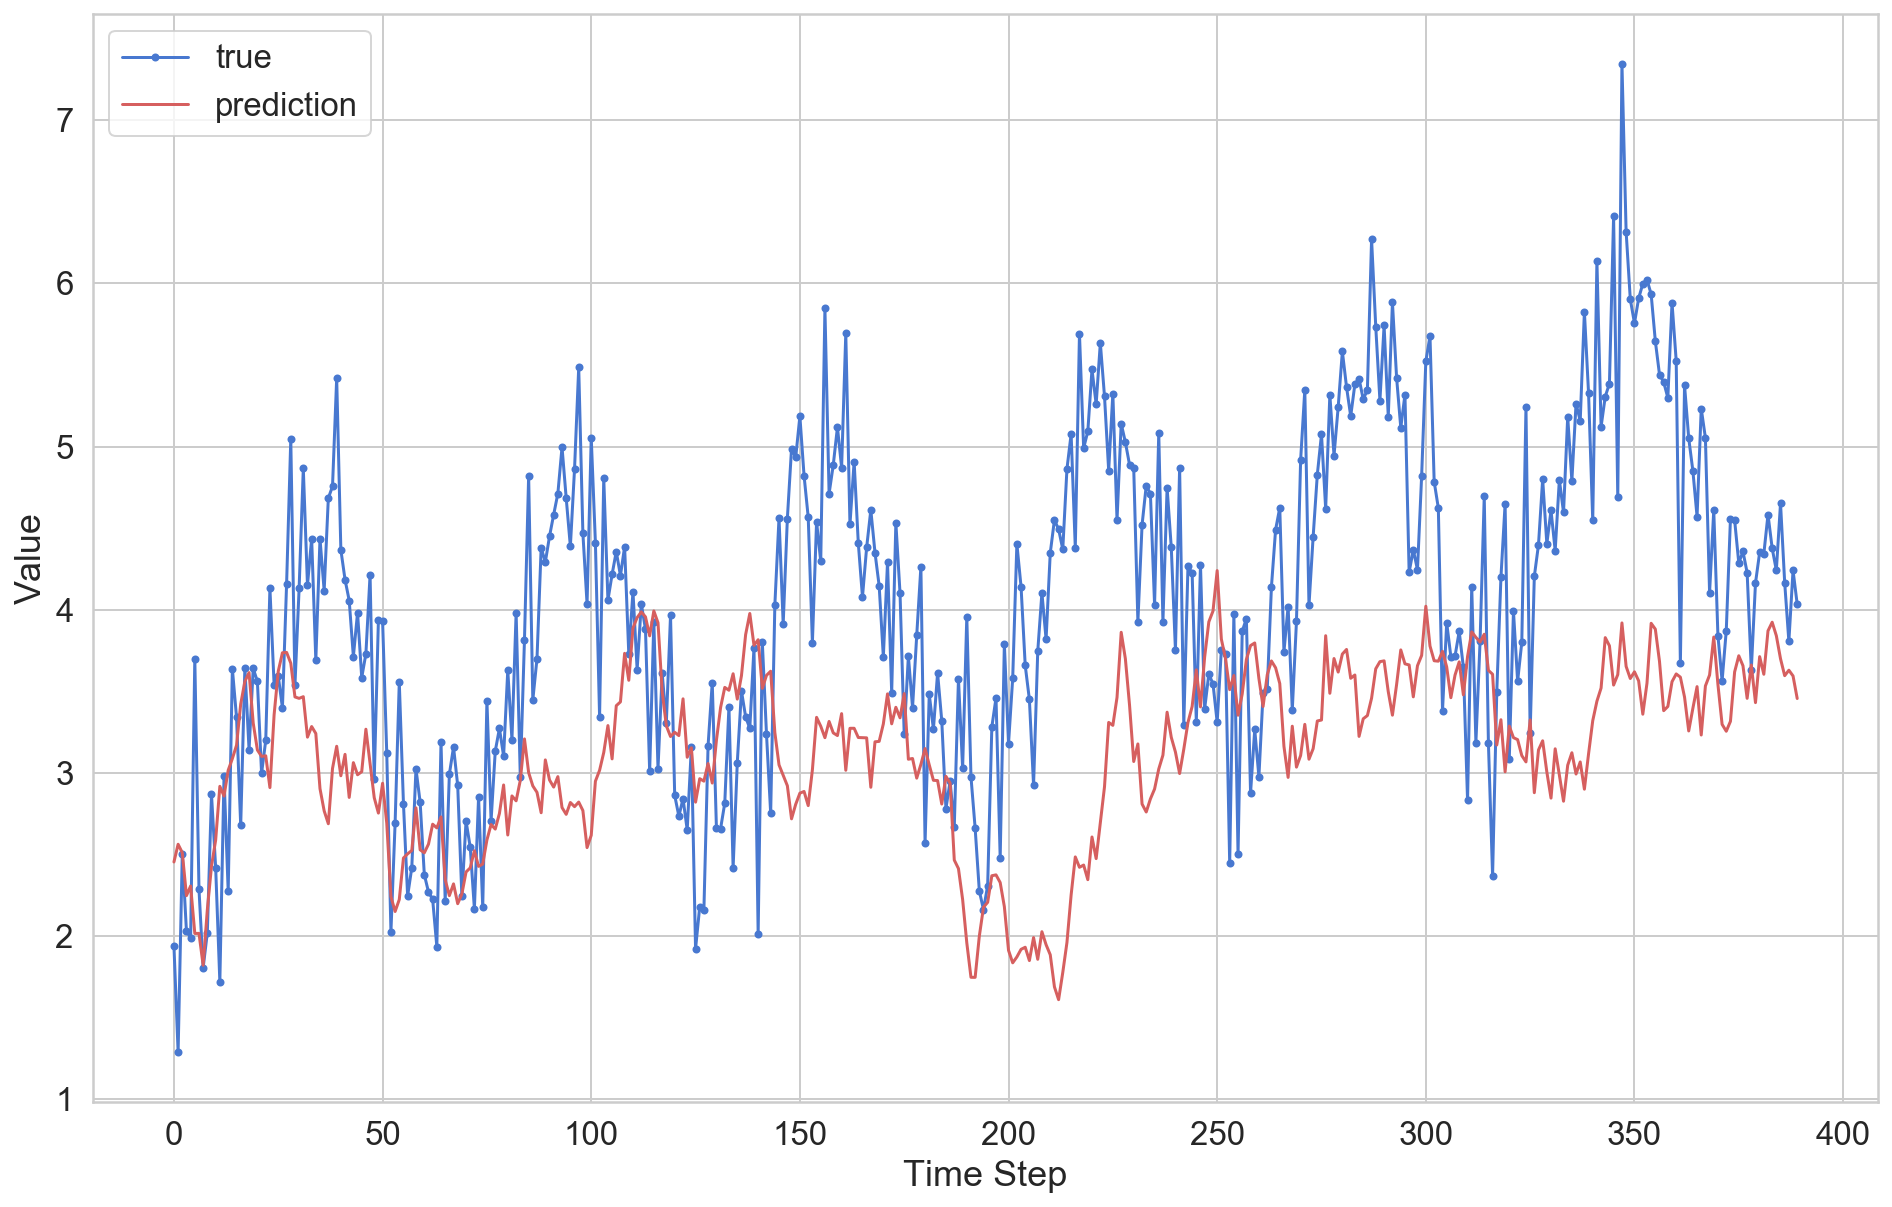

In [14]:
nSteps = X_test.shape[0]
xi = np.array([X_test[0]])
y_pred = []

for i in range(nSteps):
    yi = model.predict(xi)[0]
    y_pred.append(yi)
    xi = np.reshape([np.insert(xi[0][1:], time_steps - 1, yi + np.random.normal(scale=0.5))], (1, time_steps, 1))

plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();